In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install scikit-plot
import scikitplot as skplt
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OutputCodeClassifier
from sklearn.metrics import f1_score,fbeta_score,matthews_corrcoef, log_loss, confusion_matrix,classification_report,make_scorer,balanced_accuracy_score, plot_confusion_matrix
from sklearn.metrics import accuracy_score, roc_curve, auc,recall_score,roc_auc_score, average_precision_score, precision_score,plot_precision_recall_curve,precision_recall_curve,ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import GridSearchCV, learning_curve
from lightgbm import LGBMClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (OneHotEncoder, PowerTransformer, StandardScaler)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier


In [ ]:
!pip install scikit-plot==0.3.7


In [ ]:
df=pd.read_xlsx('predictive maintenance.xlsx')
df['Failure Type'].value_counts()

In [ ]:
!pip install openpyxl==3.1.2

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving predictive maintainence.xlsx to predictive maintainence.xlsx


In [ ]:
import pandas as pd
import io

df = pd.read_excel(io.BytesIO(uploaded['predictive maintainence.xlsx']))

In [ ]:
df['Failure Type'].value_counts()

,count
Failure Type,
No Failure,9652
Heat Dissipation Failure,112
Power Failure,95
Overstrain Failure,78
Tool Wear Failure,45
Random Failures,18


In [ ]:
df

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Failure Type
0,298.1,308.6,1551,42.8,0,No Failure
1,298.2,308.7,1408,46.3,3,No Failure
2,298.1,308.5,1498,49.4,5,No Failure
3,298.2,308.6,1433,39.5,7,No Failure
4,298.2,308.7,1408,40.0,9,No Failure
...,...,...,...,...,...,...
9995,298.8,308.4,1604,29.5,14,No Failure
9996,298.9,308.4,1632,31.8,17,No Failure
9997,299.0,308.6,1645,33.4,22,No Failure
9998,299.0,308.7,1408,48.5,25,No Failure


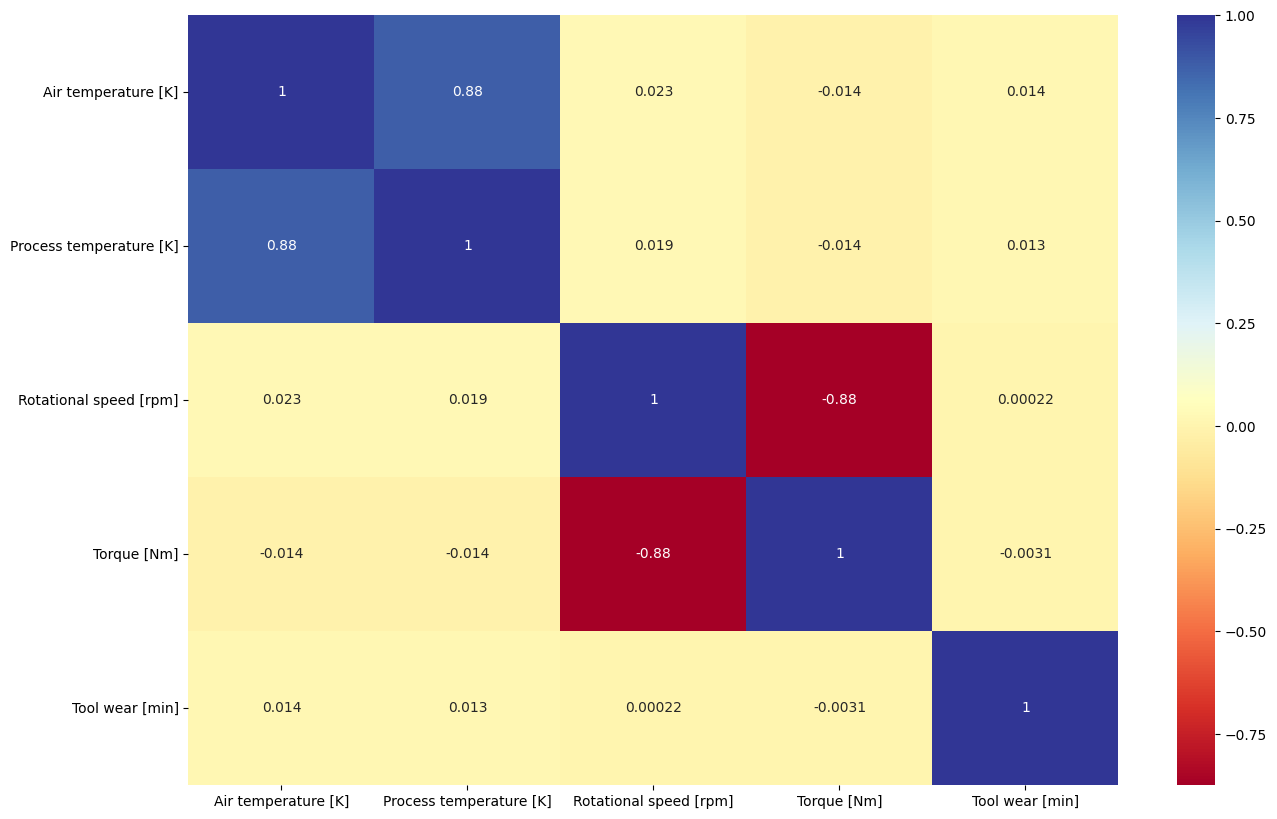

In [ ]:
numerical_df = df.select_dtypes(include=np.number)
plt.figure(figsize=(15, 10))
sns.heatmap(numerical_df.corr(), annot=True, cmap="RdYlBu")
plt.draw()

In [ ]:
df.isnull().values.any()

False

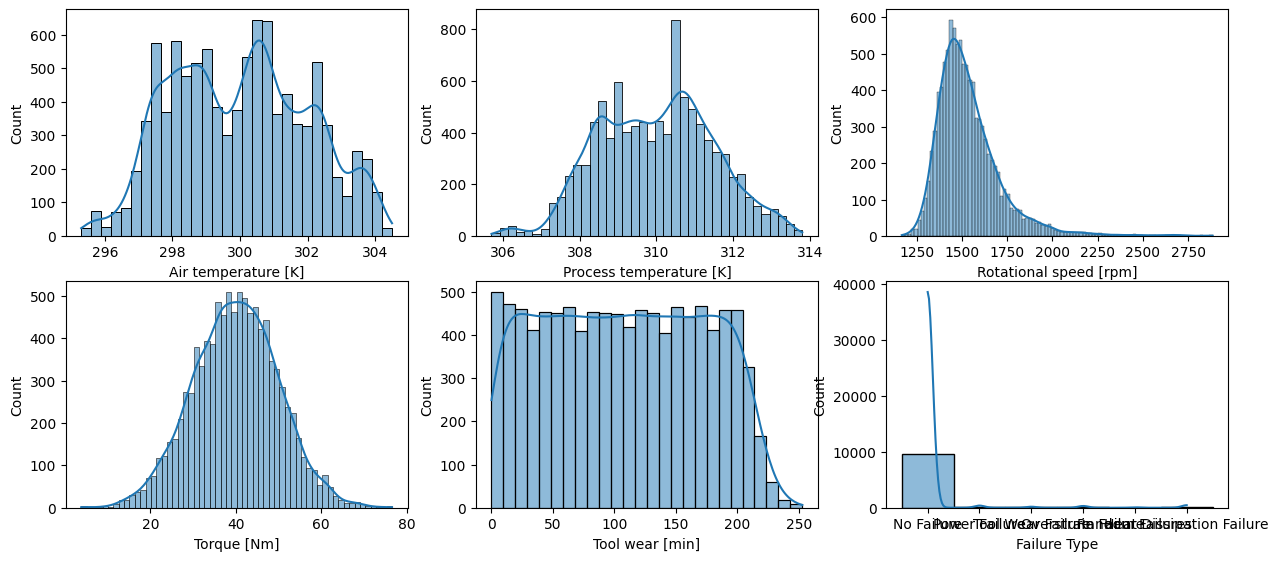

In [ ]:
plt.figure(figsize=(15,10))
for i,col in enumerate(df.columns,1):
    plt.subplot(3,3,i)
    sns.histplot(df[col],kde=True)

array([[<Axes: title={'center': 'Air temperature [K]'}>,
        <Axes: title={'center': 'Process temperature [K]'}>],
       [<Axes: title={'center': 'Rotational speed [rpm]'}>,
        <Axes: title={'center': 'Torque [Nm]'}>],
       [<Axes: title={'center': 'Tool wear [min]'}>, <Axes: >]],
      dtype=object)

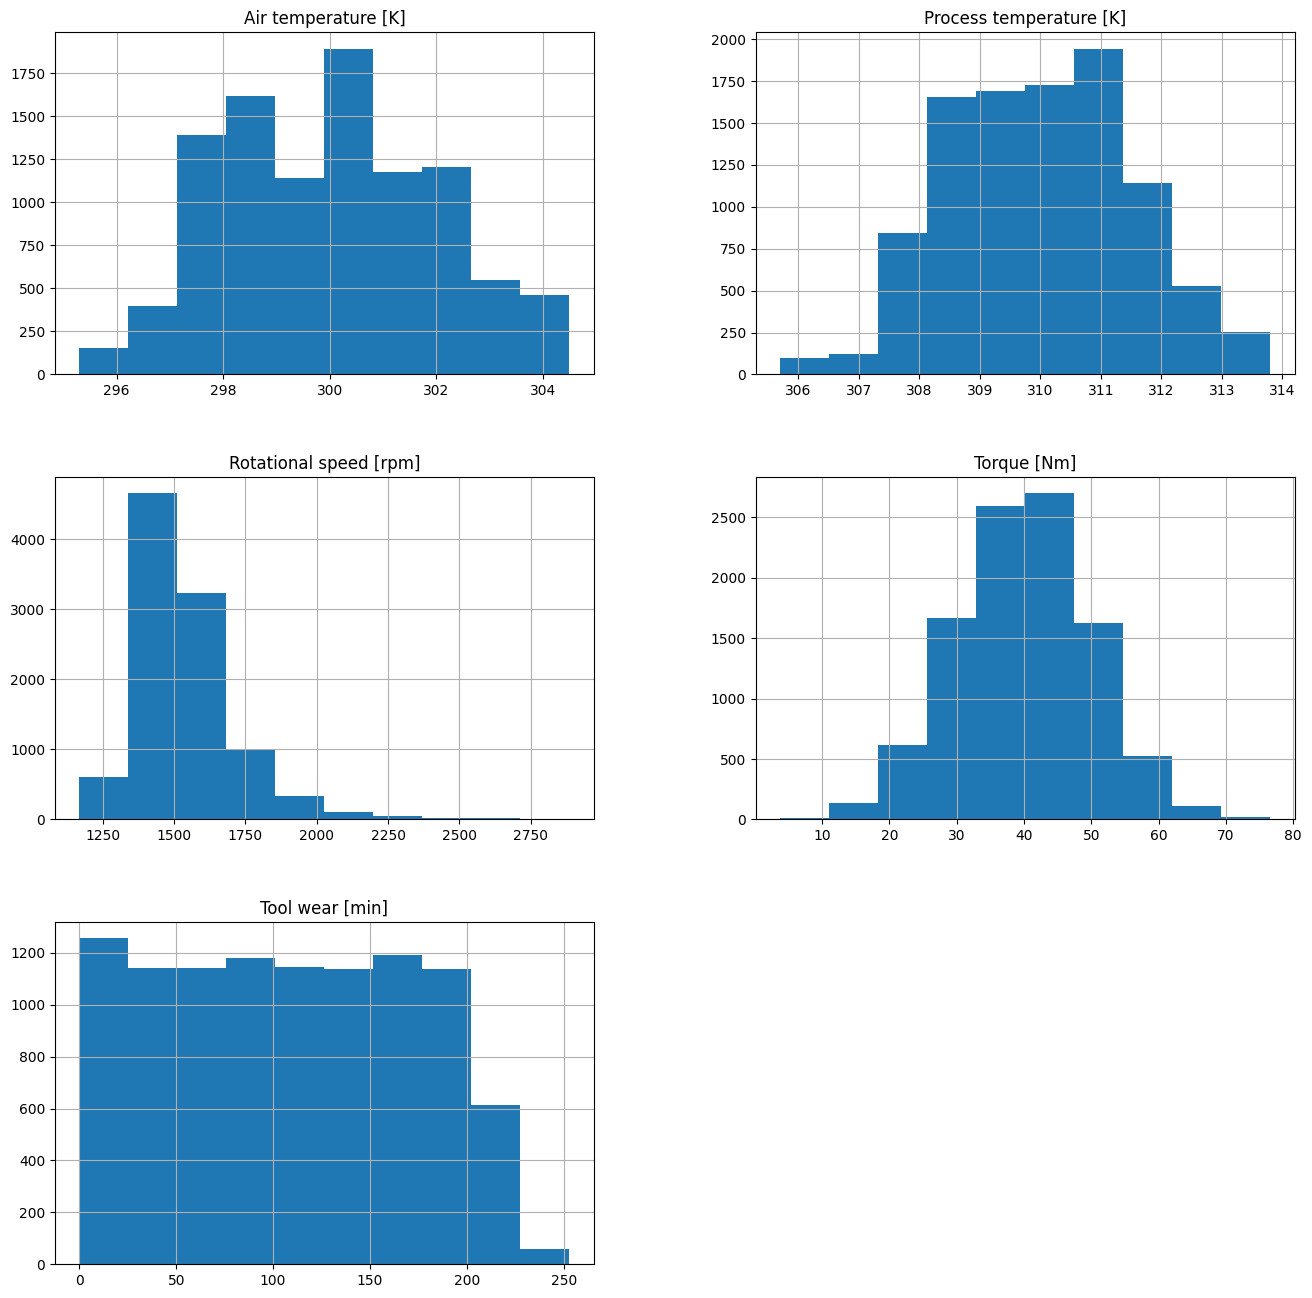

In [ ]:
df.hist(figsize=(16, 16))


In [ ]:
df.describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,300.004930,310.005560,1538.776100,39.986910,107.951000
std,2.000259,1.483734,179.284096,9.968934,63.654147
min,295.300000,305.700000,1168.000000,3.800000,0.000000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000


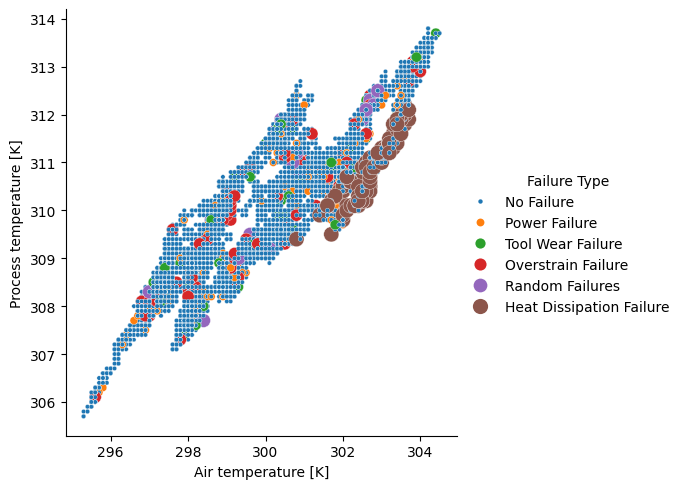

In [ ]:
_ = sns.relplot(x="Air temperature [K]", y="Process temperature [K]", hue="Failure Type",size="Failure Type", sizes=(120, 10),data=df)


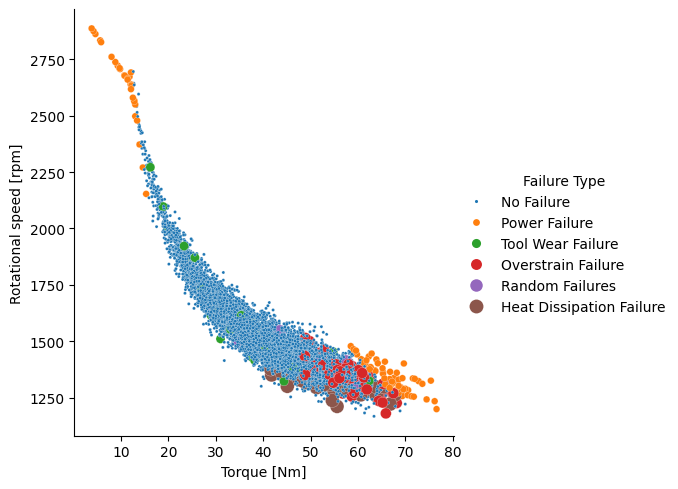

In [ ]:
_ = sns.relplot(x="Torque [Nm]", y="Rotational speed [rpm]", hue="Failure Type",size="Failure Type", sizes=(100, 5),data=df)


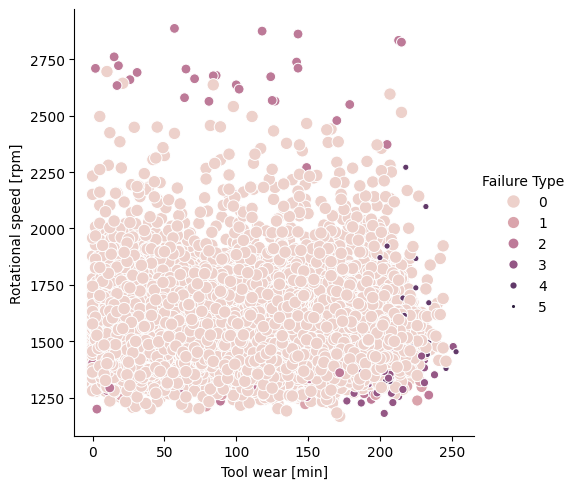

In [ ]:
_ = sns.relplot(x="Tool wear [min]",
                y="Rotational speed [rpm]",
                hue="Failure Type",
                size="Failure Type",
                sizes=(80, 5),
                data=df)

In [ ]:
df["Failure Type"].replace({"No Failure": 0,"Heat Dissipation Failure": 1,"Power Failure": 2,"Overstrain Failure": 3,"Tool Wear Failure": 4,"Random Failures": 5},inplace=True)


In [ ]:
print(df.columns)

Index(['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Failure Type'],
      dtype='object')


In [ ]:
col_name=df.columns.to_list()


In [ ]:
predictive_columns = col_name[0:6]
X = df[predictive_columns]
y = df["Failure Type"]

In [ ]:
from sklearn.model_selection import StratifiedKFold
skf=StratifiedKFold(n_splits=5, random_state=None)
for train_index,test_index in skf.split(X,y):
    x1_train,x1_test=X.iloc[train_index],X.iloc[test_index]
    y1_train,y1_test=y.iloc[train_index],y.iloc[test_index]
    train_0, train_1 = len(y1_train[y1_train==0]), len(y1_train[y1_train==1])
    test_0, test_1 = len(y1_test[y1_test==0]), len(y1_test[y1_test==1])
    print('train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))


train: 0=7721, 1=90, Test: 0=1931, 1=22
train: 0=7721, 1=90, Test: 0=1931, 1=22
train: 0=7722, 1=90, Test: 0=1930, 1=22
train: 0=7722, 1=89, Test: 0=1930, 1=23
train: 0=7722, 1=89, Test: 0=1930, 1=23


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=40, test_size=0.33, stratify=y)

In [ ]:
from imblearn.combine import SMOTETomek
smote = SMOTETomek(random_state=42)
X1_res, y1_res = smote.fit_resample(X_train,y_train)

In [ ]:
X1_res.shape

(38786, 6)

In [ ]:
X1_res

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Failure Type
0,297.500000,308.700000,1371,46.500000,121,0
1,297.400000,308.600000,1452,41.200000,197,0
2,296.400000,307.300000,2077,19.100000,80,0
3,300.400000,309.300000,1413,50.300000,101,0
4,297.400000,308.100000,1348,57.400000,66,0
...,...,...,...,...,...,...
38781,302.567982,312.035964,1437,42.908492,201,5
38782,302.766184,312.183092,1507,36.246384,79,5
38783,299.733107,309.612309,1567,35.541596,183,5
38784,302.463023,311.872267,1308,59.649157,168,5


In [ ]:
y1_res.shape

(38786,)

In [ ]:
df_x = pd.DataFrame(X1_res)

In [ ]:
df_y = pd.DataFrame(y1_res)

In [ ]:
df_y["Failure Type"].replace({0:"No Failure",1:"Heat Dissipation Failure",2:"Power Failure",3:"Overstrain Failure",4:"Tool Wear Failure",5:"Random Failures"},inplace=True)


<ipython-input-52-8e83e2020c96>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_y["Failure Type"].replace({0:"No Failure",1:"Heat Dissipation Failure",2:"Power Failure",3:"Overstrain Failure",4:"Tool Wear Failure",5:"Random Failures"},inplace=True)


In [ ]:
df1 = pd.concat([df_x,df_y], axis=1)

In [ ]:
print(df1.columns)

Index(['Air temperature [K]', 'Process temperature [K]', 'Rotational_speed',
       'Torque [Nm]', 'Tool_wear', 'Failure_Type', 'Failure_Type'],
      dtype='object')


In [ ]:
df1['Tool_wear'] = df1['Tool_wear'].astype(float)  # Convert to float if needed
df1['Rotational_speed'] = df1['Rotational_speed'].astype(float)  # Convert to float if needed

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:

rfc = OutputCodeClassifier(RandomForestClassifier(), code_size=6, random_state=40)

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numerical_features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
categorical_features = []  # If you have any

full = ColumnTransformer(
       transformers=[
           ('num', StandardScaler(), numerical_features),
           ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
       ])

In [ ]:
pipeline = Pipeline(
        steps=[("preprocess", full), ("base", rfc)])